# **AAI0026 Practice 3: GraphSage and GAT**

In Practice 2, we constructed GNN models by using PyTorch Geometric built in GCN layer, the `GCNConv`. In this Colab we will implement the **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) and **GAT** ([Veličković et al. (2018)](https://arxiv.org/abs/1710.10903)) layers directly. Then we will run our models on the CORA dataset, which is a standard citation network benchmark dataset.


**Note**: Make sure to **sequentially run all the cells in each section**, so that the intermediate variables / packages will carry over to the next cell.

# Device
You might need to use GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

## Installation

In [1]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

     |████████████████████████████████| 2.1 MB 33.0 MB/s 
     |████████████████████████████████| 467 kB 29.3 MB/s 


In [2]:
import torch_geometric
torch_geometric.__version__

'2.1.0'

# 1 GNN Layers

## Implementing Layer Modules

In colab 2, we implemented a network using GCN in node and graph classification tasks. However, the GCN module we used in colab 2 is from the official library. For this problem, we will provide you with a general Graph Neural Network Stack, where you'll be able to plugin your own modules of GraphSAGE and GATs. We will use our implementations to complete node classification on CORA, which is a standard citation network benchmark dataset. In this dataset, nodes correspond to documents and edges correspond to undirected citations. Each node has a class label. The node features are elements of a bag-or-words representation of a document. For the Cora dataset, there are 2708 nodes, 5429 edges, 7 prediction classes for nodes, and 1433 features per node. 

## GNN Stack Module

Below is the implementation for a general GNN Module that could plugin any layers, including **GraphSage**, **GAT**, etc. This module is provided for you, and your own **GraphSage** and **GAT** layers will function as components in the GNNStack Module.

In [3]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
# https://greeksharifa.github.io/pytorch/2021/09/04/MP/
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            # When applying GAT with num heads > 1, one needs to modify the 
            # input and output dimension of the conv layers (self.convs),
            # to ensure that the input dim of the next layer is num heads
            # multiplied by the output dim of the previous layer.
            # HINT: In case you want to play with multiheads, you need to change the for-loop when builds up self.convs to be
            # self.convs.append(conv_model(hidden_dim * num_heads, hidden_dim)), 
            # and also the first nn.Linear(hidden_dim * num_heads, hidden_dim) in post-message-passing.
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
          
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

## GraphSage Implementation

Now let's start working on our own implementation of layers! This part is to get you familiar with how to implement Pytorch layer based on Message Passing. You will be implementing the **forward**, **message** and **aggregate** functions.

Generally, the **forward** function is where the actual message passing is conducted. All logic in each iteration happens in **forward**, where we'll call **propagate** function to propagate information from neighbor nodes to central nodes.  So the general paradigm will be pre-processing -> propagate -> post-processing.

Recall the process of message passing we introduced. **propagate** further calls **message** which transforms information of neighbor nodes into messages, **aggregate** which aggregates all messages from neighbor nodes into one, and **update** which further generates the embedding for nodes in the next iteration.

Our implementation is slightly variant from this, where we'll not explicitly implement **update**, but put the logic for updating nodes in **forward** function. To be more specific, after information is propagated, we can further conduct some operations on the output of **propagate**. The output of **forward** is exactly the embeddings after the current iteration.

In addition, tensors passed to **propagate()** can be mapped to the respective nodes $i$ and $j$ by appending _i or _j to the variable name, .e.g. x_i and x_j. Note that we generally refer to $i$ as the central nodes that aggregates information, and refer to $j$ as the neighboring nodes, since this is the most common notation.

Please find more details in the comments. One thing to note is that we're adding **skip connections** to our GraphSage. Formally, the update rule for our model is described as below:

\begin{equation}
h_v^{(l)} = W_l\cdot h_v^{(l-1)} + W_r \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

For simplicity, we use mean aggregations where:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

Additionally, $\ell$-2 normalization is applied after each iteration.

In order to complete the work correctly, we have to understand how the different functions interact with each other. In **propagate** we can pass in any parameters we want. For example, we pass in $x$ as an parameter:

... = propagate(..., $x$=($x_{central}$, $x_{neighbor}$), ...)

Here $x_{central}$ and $x_{neighbor}$ represent the features from **central** nodes and from **neighbor** nodes. If we're using the same representations from central and neighbor, then $x_{central}$ and $x_{neighbor}$ could be identical.

Suppose $x_{central}$ and $x_{neighbor}$ are both of shape N * d, where N is number of nodes, and d is dimension of features.

Then in message function, we can take parameters called $x\_i$ and $x\_j$. Usually $x\_i$ represents "central nodes", and $x\_j$ represents "neighbor nodes". Pay attention to the shape here: $x\_i$ and $x\_j$ are both of shape E * d (**not N!**). $x\_i$ is obtained by concatenating the embeddings of central nodes of all edges through lookups from $x_{central}$ we passed in propagate. Similarly, $x\_j$ is obtained by concatenating the embeddings of neighbor nodes of all edges through lookups from $x_{neighbor}$ we passed in propagate.

Let's look at an example. Suppose we have 4 nodes, so $x_{central}$ and $x_{neighbor}$ are of shape 4 * d. We have two edges (1, 2) and (3, 0). Thus, $x\_i$ is obtained by $[x_{central}[1]^T; x_{central}[3]^T]^T$, and $x\_j$ is obtained by $[x_{neighbor}[2]^T; x_{neighbor}[0]^T]^T$

<font color='red'>For the following questions, DON'T refer to any existing implementations online.</font>

In [5]:
class GraphSage(MessagePassing):
    
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):  
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = None
        self.lin_r = None

        ############################################################################
        # TODO: Your code here! 
        # Define the layers needed for the message and update functions below.
        # self.lin_l is the linear transformation that you apply to embedding 
        #            for central node.
        # self.lin_r is the linear transformation that you apply to aggregated 
        #            message from neighbors.
        # Our implementation is ~2 lines, but don't worry if you deviate from this.

        self.lin_l = torch.nn.Linear(self.in_channels, self.out_channels)
        self.lin_r = torch.nn.Linear(self.in_channels, self.out_channels)

        ############################################################################

        self.reset_parameters()


    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        """"""

        out = None

        ############################################################################
        # TODO: Your code here! 
        # Implement message passing, as well as any post-processing (our update rule).
        # 1. First call propagate function to conduct the message passing.
        #    1.1 See there for more information: 
        #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        #    1.2 We use the same representations for central (x_central) and 
        #        neighbor (x_neighbor) nodes, which means you'll pass x=(x, x) 
        #        to propagate.
        # 2. Update our node embedding with skip connection.
        # 3. If normalize is set, do L-2 normalization (defined in 
        #    torch.nn.functional)
        # Our implementation is ~5 lines, but don't worry if you deviate from this.

        out = self.propagate(edge_index, x=x, size=size)
        out= self.lin_r(out)
        x = self.lin_l(x)
        dout = x + out

        ############################################################################

        return out

    def message(self, x_j):

        out = None

        ############################################################################
        # TODO: Your code here! 
        # Implement your message function here.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.

        ############################################################################

        return out

    def aggregate(self, inputs, index, dim_size = None):

        out = None

        # The axis along which to index number of nodes.
        node_dim = self.node_dim

        ############################################################################
        # TODO: Your code here! 
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: 
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        out = torch_scatter.scatter(inputs, index, self.node_dim,dim_size = dim_size, reduce = 'mean')

        ############################################################################

        return out


## GAT Implementation

Attention mechanisms have become the state-of-the-art in many sequence-based tasks such as machine translation and learning sentence representations. One of the major benefits of attention-based mechanisms is their ability to focus on the most relevant parts of the input to make decisions. In this problem, we will see how attention mechanisms can be used to perform node classification of graph-structured data through the usage of Graph Attention Networks (GATs).

The building block of the Graph Attention Network is the graph attention layer, which is a variant of the aggregation function . Let $N$ be the number of nodes and $F$ be the dimension of the feature vector for each node. The input to each graph attentional layer is a set of node features: $\mathbf{h} = \{\overrightarrow{h_1}, \overrightarrow{h_2}, \dots, \overrightarrow{h_N}$\}, $\overrightarrow{h_i} \in R^F$. The output of each graph attentional layer is a new set of node features, which may have a new dimension $F'$: $\mathbf{h'} = \{\overrightarrow{h_1'}, \overrightarrow{h_2'}, \dots, \overrightarrow{h_N'}\}$, with $\overrightarrow{h_i'} \in \mathbb{R}^{F'}$.

We will now describe this transformation of the input features into higher-level features performed by each graph attention layer. First, a shared linear transformation parametrized by the weight matrix $\mathbf{W} \in \mathbb{R}^{F' \times F}$ is applied to every node. Next, we perform self-attention on the nodes. We use a shared attentional mechanism:
\begin{equation} 
a : \mathbb{R}^{F'} \times \mathbb{R}^{F'} \rightarrow \mathbb{R}.
\end{equation}

This mechanism computes the attention coefficients that capture the importance of node $j$'s features to node $i$:
\begin{equation}
e_{ij} = a(\mathbf{W_l}\overrightarrow{h_i}, \mathbf{W_r} \overrightarrow{h_j})
\end{equation}
The most general formulation of self-attention allows every node to attend to all other nodes which drops all structural information. To utilize graph structure in the attention mechanisms, we can use masked attention. In masked attention, we only compute $e_{ij}$ for nodes $j \in \mathcal{N}_i$ where $\mathcal{N}_i$ is some neighborhood of node $i$ in the graph.

To easily compare coefficients across different nodes, we normalize the coefficients across $j$ using a softmax function:
\begin{equation}
\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} \exp(e_{ik})}
\end{equation}

For this problem, our attention mechanism $a$ will be a single-layer feedforward neural network parametrized by a weight vector $\overrightarrow{a} \in \mathbb{R}^{F'}$, followed by a LeakyReLU nonlinearity (with negative input slope 0.2). Let $\cdot^T$ represent transposition and $||$ represent concatenation. The coefficients computed by our attention mechanism may be expressed as:

\begin{equation}
\alpha_{ij} = \frac{\exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_j}\Big)\Big)}{\sum_{k\in \mathcal{N}_i} \exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_k}\Big)\Big)}
\end{equation}

For the following questions, we denote $\alpha_l = [...,\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i},...]$ and $\alpha_r = [..., \overrightarrow{a_r}^T \mathbf{W_r} \overrightarrow{h_j}, ...]$.


At every layer of GAT, after the attention coefficients are computed for that layer, the aggregation function can be computed by a weighted sum of neighborhood messages, where weights are specified by $\alpha_{ij}$.

Now, we use the normalized attention coefficients to compute a linear combination of the features corresponding to them. These aggregated features will serve as the final output features for every node.

\begin{equation}
h_i' = \sum_{j \in \mathcal{N}_i} \alpha_{ij} \mathbf{W_r} \overrightarrow{h_j}.
\end{equation}

To stabilize the learning process of self-attention, we use multi-head attention. To do this we use $K$ independent attention mechanisms, or ``heads'' compute output features as in the above equations. Then, we concatenate these output feature representations:

\begin{equation}
    \overrightarrow{h_i}' = ||_{k=1}^K \Big(\sum_{j \in \mathcal{N}_i} \alpha_{ij}^{(k)} \mathbf{W_r}^{(k)} \overrightarrow{h_j}\Big)
\end{equation}

where $||$ is concentation, $\alpha_{ij}^{(k)}$ are the normalized attention coefficients computed by the $k$-th attention mechanism $(a^k)$, and $\mathbf{W}^{(k)}$ is the corresponding input linear transformation's weight matrix. Note that for this setting, $\mathbf{h'} \in \mathbb{R}^{KF'}$.

In [10]:
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None

        ############################################################################
        # TODO: Your code here! 
        # Define the layers needed for the message functions below.
        # self.lin_l is the linear transformation that you apply to embeddings 
        # BEFORE message passing.
        # Pay attention to dimensions of the linear layers, since we're using 
        # multi-head attention.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.

        self.lin_l = torch.nn.Linear(in_channels, heads * out_channels)

        ############################################################################

        self.lin_r = self.lin_l

        ############################################################################
        # TODO: Your code here! 
        # Define the attention parameters \overrightarrow{a_l/r}^T in the above intro.
        # You have to deal with multi-head scenarios.
        # Use nn.Parameter instead of nn.Linear
        # Our implementation is ~2 lines, but don't worry if you deviate from this.

        self.att_l = Parameter(torch.Tensor(1, self.heads, out_channels))
        self.att_r = Parameter(torch.Tensor(1, self.heads, out_channels))

        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):
        
        H, C = self.heads, self.out_channels

        ############################################################################
        # TODO: Your code here! 
        # Implement message passing, as well as any pre- and post-processing (our update rule).
        # 1. First apply linear transformation to node embeddings, and split that 
        #    into multiple heads. We use the same representations for source and
        #    target nodes, but apply different linear weights (W_l and W_r)
        # 2. Calculate alpha vectors for central nodes (alpha_l) and neighbor nodes (alpha_r).
        # 3. Call propagate function to conduct the message passing. 
        #    3.1 Remember to pass alpha = (alpha_l, alpha_r) as a parameter.
        #    3.2 See there for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        # 4. Transform the output back to the shape of N * d.
        # Our implementation is ~5 lines, but don't worry if you deviate from this.

        x_l = self.lin_l(x).reshape(-1, H, C)
        x_r = self.lin_r(x).reshape(-1, H, C)
        alpha_l = self.att_l * x_l
        alpha_r = self.att_r * x_r
        out = self.propagate(edge_index, x=(x_l, x_r), alpha=(alpha_l, alpha_r), size=size)
        out = out.reshape(-1, H*C)
        ############################################################################

        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        ############################################################################
        # TODO: Your code here! 
        # Implement your message function. Putting the attention in message 
        # instead of in update is a little tricky.
        # 1. Calculate the final attention weights using alpha_i and alpha_j,
        #    and apply leaky Relu.
        # 2. Calculate softmax over the neighbor nodes for all the nodes. Use 
        #    torch_geometric.utils.softmax instead of the one in Pytorch.
        # 3. Apply dropout to attention weights (alpha).
        # 4. Multiply embeddings and attention weights. As a sanity check, the output
        #    should be of shape E * H * d.
        # 5. ptr (LongTensor, optional): If given, computes the softmax based on
        #    sorted inputs in CSR representation. You can simply pass it to softmax.
        # Don't worry if you deviate from this.

        alpha = F.leaky_relu(alpha_i + alpha_j, negative_slope=self.negative_slope)
        if ptr:
            att_weight = F.softmax(alpha_i + alpha_j, ptr)
        else:
            att_weight = torch_geometric.utils.softmax(alpha, index)
        # Fill below with 2 lines 
        alpha = F.dropout(alpha, p=self.dropout)
        out = alpha.unsqueeze(-1)* x_j
        
        ############################################################################

        return out


    def aggregate(self, inputs, index, dim_size = None):

        ############################################################################
        # TODO: Your code here! 
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: https://pytorch-scatter.readthedocs.io/en/latest/_modules/torch_scatter/scatter.html
        # Pay attention to "reduce" parameter is different from that in GraphSage.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        
        out = torch_scatter.scatter(inputs, index, self.node_dim, dim_size=dim_size, reduce='sum')
        ############################################################################
    
        return out

## Building Optimizers

This function has been implemented for you. **For grading purposes please use the default Adam optimizer**, but feel free to play with other types of optimizers on your own.

In [11]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

## Training and Testing

Here we provide you with the functions to train and test. **Please do not modify this part for grading purposes.**

In [12]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    
    print("Node task. test set size:", np.sum(dataset[0]['train_mask'].numpy()))
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
          print("Epoch ", epoch, "Loss: ", total_loss, "Test Acc.: ", test_acc)
        else:
          test_accs.append(test_accs[-1])
    return test_accs, losses

def test(loader, model, is_validation=True):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y[mask]
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()
    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


## Let's Start the Training!

We will be working on the CORA dataset on node-level classification.

This part is implemented for you. **For grading purposes, please do not modify the default parameters.** However, feel free to play with different configurations just for fun!

**Submit your best accuracy and loss on Gradescope.**

In [13]:
# GraphSage

def main():
    for args in [
        {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 
         'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.01},
    ]:
        args = objectview(args)
        for model in ['GraphSage']:
            args.model_type = model

            # Match the dimension.
            if model == 'GAT':
              args.heads = 2
            else:
              args.heads = 1

            if args.dataset == 'cora':
                dataset = Planetoid(root='/tmp/cora', name='Cora')
            else:
                raise NotImplementedError("Unknown dataset") 
            test_accs, losses = train(dataset, args) 

            print("Maximum accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()

if __name__ == '__main__':
    main()

Node task. test set size: 140


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


AttributeError: ignored

Node task. test set size: 140
Epoch  0 Loss:  1.9566068649291992 Test Acc.:  0.104
Epoch  10 Loss:  1.0250568389892578 Test Acc.:  0.486
Epoch  20 Loss:  0.2713371515274048 Test Acc.:  0.674
Epoch  30 Loss:  0.13003231585025787 Test Acc.:  0.722
Epoch  40 Loss:  0.09789977967739105 Test Acc.:  0.712
Epoch  50 Loss:  0.11593309044837952 Test Acc.:  0.678
Epoch  60 Loss:  0.09242720901966095 Test Acc.:  0.666
Epoch  70 Loss:  0.12858586013317108 Test Acc.:  0.722
Epoch  80 Loss:  0.04588910937309265 Test Acc.:  0.726
Epoch  90 Loss:  0.09208666533231735 Test Acc.:  0.718
Epoch  100 Loss:  0.05639316514134407 Test Acc.:  0.726
Epoch  110 Loss:  0.08017326891422272 Test Acc.:  0.71
Epoch  120 Loss:  0.09598377346992493 Test Acc.:  0.732
Epoch  130 Loss:  0.050167299807071686 Test Acc.:  0.704
Epoch  140 Loss:  0.04777543619275093 Test Acc.:  0.734
Epoch  150 Loss:  0.05792825669050217 Test Acc.:  0.72
Epoch  160 Loss:  0.05302969738841057 Test Acc.:  0.728
Epoch  170 Loss:  0.0705915614962

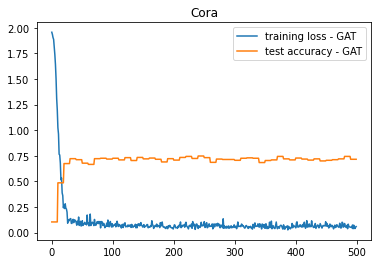

In [ ]:
# GAT
def main():
    for args in [
        {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 
         'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.01},
    ]:
        args = objectview(args)
        for model in ['GAT']:
            args.model_type = model

            # Match the dimension.
            if model == 'GAT':
              args.heads = 2
            else:
              args.heads = 1

            if args.dataset == 'cora':
                dataset = Planetoid(root='/tmp/cora', name='Cora')
            else:
                raise NotImplementedError("Unknown dataset") 
            test_accs, losses = train(dataset, args) 

            print("Maximum accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()

if __name__ == '__main__':
    main()

## Question 1.1: What is the maximum accuracy you could get on test set for GraphSage?

Maximum accuracy:

## Question 1.2: What is the maximum accuracy you could get on test set for GAT?

Maximum accuracy:

# Submission

In order to get credit, you need to submit the `ipynb` file of Colab 3 to LMS.
To get this file, click `File` and `Download .ipynb`. Please make sure that your output of each cell is available in your `ipynb` file.